In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.api.models import Sequential, load_model
from keras.api.layers import Dense
import os

In [2]:
train_data = pd.read_csv('my_data.csv')
X_data = train_data[['x2', 'y2']].to_numpy()
Y_data = train_data[['q1', 'q2']].to_numpy()


from sklearn.model_selection import train_test_split

X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_data, Y_data, test_size=0.15, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42
)


In [3]:
def mdn_loss(y_true, y_pred):
    n_components = 2
    n_dims = 2

    # Split model outputs and process outputs
    out_pi = y_pred[:, :n_components]
    out_mu = y_pred[:, n_components:n_components + n_components * n_dims]
    out_sigma = y_pred[:, n_components + n_components * n_dims:]

    pi = tf.nn.softmax(out_pi)
    mu = tf.reshape(out_mu, [-1, n_components, n_dims])
    sigma = tf.exp(out_sigma)
    sigma = tf.reshape(sigma, [-1, n_components, n_dims])

    y_true_exp = tf.reshape(y_true, [-1, 1, n_dims])

    # Normalized difference
    norm = (y_true_exp - mu) / sigma

    # Exponent term
    exponent = -0.5 * tf.reduce_sum(tf.square(norm), axis=2)

    # Normalizing coefficient
    coeff = 1.0 / (2.0 * np.pi * tf.reduce_prod(sigma, axis=2))

    # Gaussian component density
    gauss = coeff * tf.exp(exponent)

    
    weighted = pi * gauss
    total_prob = tf.reduce_sum(weighted, axis=1) + 1e-8

    loss = -tf.math.log(total_prob)
    return tf.reduce_mean(loss)


In [4]:
def build_mdn_model():
    model = Sequential([
        Dense(50, activation='relu', input_shape=(2,)),
        Dense(50, activation='relu'),
        Dense(50, activation='relu'),
        Dense(50, activation='relu'),
        Dense(10)
    ])
    return model

In [5]:
model_path = 'my_mdn_model_50_50_50_50.keras'
if os.path.exists(model_path):
    model = load_model(model_path, custom_objects={'mdn_loss': mdn_loss})
else:
    model = build_mdn_model()
    model.compile(optimizer='adam', loss=mdn_loss)
    model.summary()

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, Y_val)
    )
    model.save(model_path)

C:\Users\yanto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,310 (32.46 KB)

 Trainable params: 8,310 (32.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.8396 - val_loss: 0.8374
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6323 - val_loss: 0.3952
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2964 - val_loss: 0.3313
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2338 - val_loss: 0.3170
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1286 - val_loss: 0.2837
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1817 - val_loss: 0.2937
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1363 - val_loss: 0.2249
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - val_loss: 0.2223
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0758 - val_loss: 0.2196
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1047 - val_loss: 0.2080
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0464 - val_loss: 0.1783
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [6]:
pred = model.predict(X_test)

def decode_mdn_output(pred):
    n_components = 2
    n_dims = 2

    pi_logits = pred[:, :n_components]
    pi = tf.nn.softmax(pi_logits).numpy()

    mu = pred[:, n_components:n_components + n_components * n_dims]
    mu = mu.reshape(-1, n_components, n_dims)

    sigma = pred[:, n_components + n_components * n_dims:]
    sigma = np.exp(sigma).reshape(-1, n_components, n_dims)

    return pi, mu, sigma

pi, mu, sigma = decode_mdn_output(pred)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [7]:
for i in range(6):
    print(f"Sample {i+1}:")
    print(f"  Input Cartesian (x2, y2): {X_test[i]}")
    print(f"  True joint angles (q1, q2): {Y_test[i]}")
    print(f"  Mixing probabilities: {pi[i]}")
    print(f"  Solution 1 mean (q1, q2): {mu[i, 0]} sigma: { sigma[i, 0]}")
    print(f"  Solution 2 mean (q1, q2): {mu[i, 1]} sigma: {sigma[i, 1]}")
    print()

Sample 1:
  Input Cartesian (x2, y2): [1.05205118 1.69435828]
  True joint angles (q1, q2): [0.94034066 0.14959965]
  Mixing probabilities: [0.26485357 0.73514646]
  Solution 1 mean (q1, q2): [0.9880435  0.03172749] sigma: [0.03096668 0.06459866]
  Solution 2 mean (q1, q2): [0.95350707 0.09502492] sigma: [0.02443452 0.05597523]

Sample 2:
  Input Cartesian (x2, y2): [ 1.27828327 -1.53446549]
  True joint angles (q1, q2): [-0.82279808 -0.10685689]
  Mixing probabilities: [0.5191793  0.48082075]
  Solution 1 mean (q1, q2): [-0.80347294 -0.13690998] sigma: [0.02226751 0.04698759]
  Solution 2 mean (q1, q2): [-0.9496043   0.15807387] sigma: [0.02322148 0.04161646]

Sample 3:
  Input Cartesian (x2, y2): [ 1.2434928  -1.55929065]
  True joint angles (q1, q2): [-0.82279808 -0.14959965]
  Mixing probabilities: [0.52413756 0.47586247]
  Solution 1 mean (q1, q2): [-0.8211879  -0.14917736] sigma: [0.02222789 0.0466732 ]
  Solution 2 mean (q1, q2): [-0.9794958   0.16951218] sigma: [0.0232846  0.04

(375, 2)


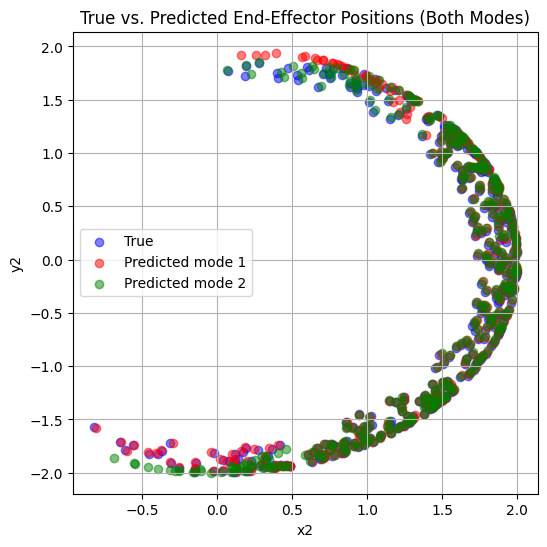

In [ ]:
def forward_kinematics_np(q):
    L1 = 1.0
    L2 = 1.0
    q1 = q[:, 0]
    q2 = q[:, 1]
    x2 = L1 * np.cos(q1) + L2 * np.cos(q1 + q2)
    y2 = L1 * np.sin(q1) + L2 * np.sin(q1 + q2)
    return np.stack([x2, y2], axis=1)

# Plot solutions in Cartesian space
plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0], X_test[:,1], color='blue', alpha=0.5, label='True')

# Plot both predicted modes for all test samples
x2y2_mode1 = forward_kinematics_np(mu[:,0,:])
x2y2_mode2 = forward_kinematics_np(mu[:,1,:])
plt.scatter(x2y2_mode1[:,0], x2y2_mode1[:,1], color='red', alpha=0.5, label='Predicted mode 1')
plt.scatter(x2y2_mode2[:,0], x2y2_mode2[:,1], color='green', alpha=0.5, label='Predicted mode 2')

plt.legend()
plt.xlabel('x2')
plt.ylabel('y2')
plt.title('True vs. Predicted End-Effector Positions (Both Modes)')
plt.grid()
plt.show()

In [9]:
def plot_robot(q1, q2, color='red', label='Predicted'):
    L1 = 1.0
    L2 = 1.0
    x1 = L1 * np.cos(q1)
    y1 = L1 * np.sin(q1)
    x2 = x1 + L2 * np.cos(q1 + q2)
    y2 = y1 + L2 * np.sin(q1 + q2)
    plt.plot([0, x1, x2], [0, y1, y2], color=color, marker='o', label=label)
    plt.axis('equal')

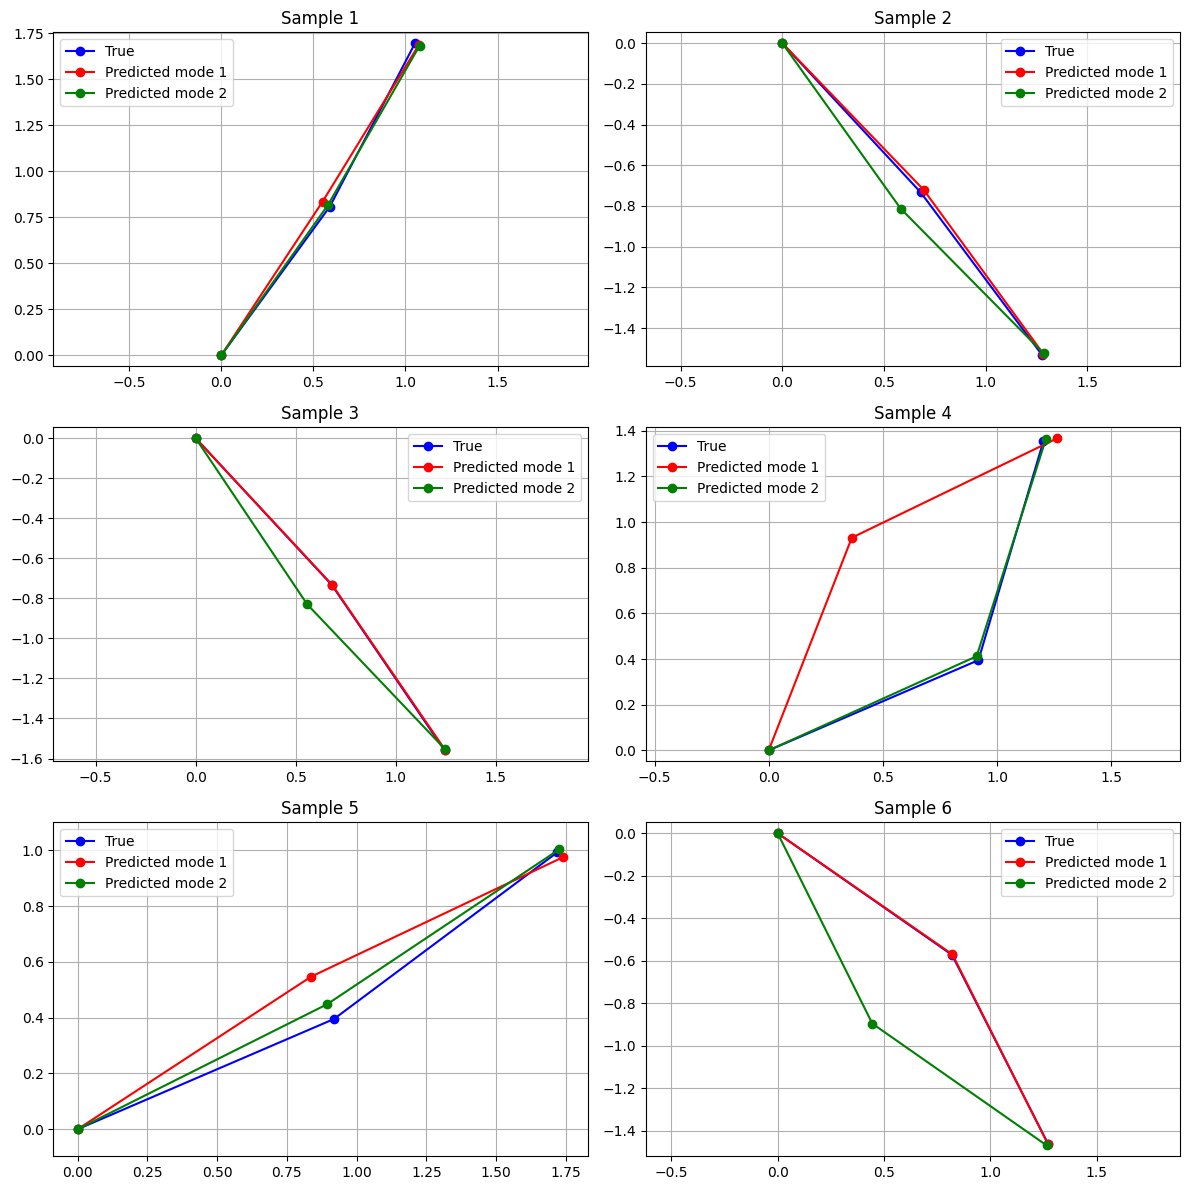

In [10]:
num_samples = 6
plt.figure(figsize=(12, 12))

for i in range(num_samples):
    plt.subplot(3, 2, i+1)

    # Ground-truth (blue)
    plot_robot(Y_test[i, 0], Y_test[i, 1], color='blue', label='True')

    # Predicted mode 1 (red)
    plot_robot(mu[i, 0, 0], mu[i, 0, 1], color='red', label='Predicted mode 1')

    # Predicted mode 2 (green)
    plot_robot(mu[i, 1, 0], mu[i, 1, 1], color='green', label='Predicted mode 2')

    plt.title(f'Sample {i+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()